In [ ]:
import zipfile
import os
import random
import pandas as pd
import numpy as np
from torch import nn
from torchvision import models
from torch.utils.data import Dataset
import torch
import cv2
from google.colab.patches import cv2_imshow


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
data_path = "/content/drive/MyDrive/Colab Notebooks/autonomous_driving/DATA.11.08.23"
DATASETS_ID = ["Dataset7_right", "Dataset8_straight", "Dataset9_straight", "Dataset10_straight", "Dataset17_recovery", "Dataset14_left", "Dataset13_left",
               "Dataset12_left", "Dataset15_left", "Dataset16_left"]
destination_map = {"left": -1,
            "straight": 0, "recovery": 0,
            "right": 1}
df = pd.DataFrame()
for dataset in DATASETS_ID:
  destination = dataset.split("_")[1]
  destination_code = destination_map[destination]
  vehicle_data_path = f'{data_path}/{dataset}/VehicleData.txt'
  print("Reading: ", vehicle_data_path)
  folder_dir = os.path.dirname(vehicle_data_path)
  head, tail = os.path.split(vehicle_data_path)

  with open(vehicle_data_path, 'r') as f:
    lines = f.readlines()
  temp_dataset = []
  for data in lines:
    if data != '\n':
      try:
        img_path, throttle, brakes, steering, velocity =  data.strip('\n').split(' ')
        img_path = img_path.replace("/IMGCaptured", "IMG/Captured")
        next_row = [os.path.join(head,img_path), float(throttle), float(brakes), float(steering), float(velocity), int(destination_code)]
        temp_dataset.append(next_row)
      except ValueError as e:
        print(f'exception raised: {e} - line: {data}')
        pass
  temp_df = pd.DataFrame(temp_dataset, columns=['image_path', 'throttle', 'brakes', 'steering', 'velocity', 'destination'])
  df = pd.concat([df, temp_df])

df.groupby("destination").describe()

Reading:  /content/drive/MyDrive/Colab Notebooks/autonomous_driving/DATA.11.08.23/Dataset7_right/VehicleData.txt
Reading:  /content/drive/MyDrive/Colab Notebooks/autonomous_driving/DATA.11.08.23/Dataset8_straight/VehicleData.txt
Reading:  /content/drive/MyDrive/Colab Notebooks/autonomous_driving/DATA.11.08.23/Dataset9_straight/VehicleData.txt
exception raised: not enough values to unpack (expected 5, got 1) - line:                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      

throttle                                                         \
               count      mean       std  min       25%       50%       75%   
destination                                                                   
-1            8057.0  0.321959  0.134780  0.0  0.257807  0.336238  0.410312   
 0           13770.0  0.410231  0.129355  0.0  0.358187  0.400145  0.458242   
 1            5443.0  0.581631  0.183835  0.0  0.433551  0.541031  0.766158   

                        brakes            ...  steering           velocity  \
                  max    count      mean  ...       75%       max    count   
destination                               ...                                
-1           0.670298   8057.0  0.011184  ... -0.001172  0.690504   8057.0   
 0           1.000000  13770.0  0.008737  ...  0.011719  0.873437  13770.0   
 1           0.976761   5443.0  0.005759  ...  0.035938  0.928906   5443.0   

                                                                             \
                  mean       std       min        25%        50%        75%   
destination                                                                   
-1           28.383836  6.369825  0.000005  30.033373  30.121185  30.215873   
 0           28.674728  5.924515  0.000014  30.032753  30.131364  30.219519   
 1           28.491661  5.606621  0.000168  29.979648  30.002577  30.030378   

                        
                   max  
destination             
-1           33.683457  
 0           34.318378  
 1           30.678490  

[3 rows x 32 columns]

In [ ]:
# delete corrupted-deleted images

rows_to_keep = []
for index, row in df.iterrows():
  if not os.path.exists(row['image_path']):
    df.drop(index, inplace=True)

df

,image_path,throttle,brakes,steering,velocity,destination
0,/content/drive/MyDrive/Colab Notebooks/autonom...,0.323166,0.000000,-0.007031,22.224013,1
1,/content/drive/MyDrive/Colab Notebooks/autonom...,0.323166,0.000000,-0.007031,22.224640,1
2,/content/drive/MyDrive/Colab Notebooks/autonom...,0.323166,0.000000,-0.007031,22.225895,1
3,/content/drive/MyDrive/Colab Notebooks/autonom...,0.323166,0.000000,-0.007031,22.227149,1
4,/content/drive/MyDrive/Colab Notebooks/autonom...,0.323166,0.000000,-0.007031,22.228088,1
...,...,...,...,...,...,...
460,/content/drive/MyDrive/Colab Notebooks/autonom...,0.000000,0.346405,0.014459,0.001425,-1
461,/content/drive/MyDrive/Colab Notebooks/autonom...,0.000000,0.346405,0.014459,0.000524,-1
462,/content/drive/MyDrive/Colab Notebooks/autonom...,0.000000,0.346405,0.014459,0.001546,-1
463,/content/drive/MyDrive/Colab Notebooks/autonom...,0.000000,0.346405,0.014459,0.001251,-1


#### -

<Axes: ylabel='Frequency'>

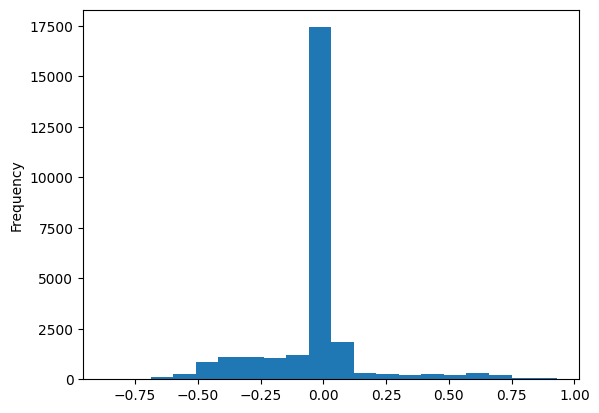

In [ ]:
df['steering'].plot.hist(bins=20)

In [ ]:
# Balance the data

threshold = 0.07
num_to_keep = 2000

around_zero_df = df[np.abs(df['steering']) <= threshold]

selected_values = around_zero_df.sample(n=num_to_keep)
df = pd.concat([selected_values, df[np.abs(df['steering']) >= threshold]])


In [ ]:
len(df[df['steering'] > 0.15])

1796

In [ ]:
threshold = -0.15
num_to_keep = 957

left_df = df[df['steering'] <= threshold]

selected_values = left_df.sample(n=num_to_keep)
df = pd.concat([selected_values, df[df['steering'] >= threshold]])

<Axes: ylabel='Frequency'>

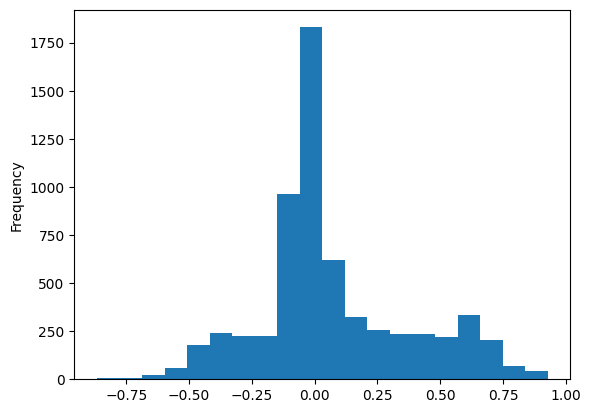

In [ ]:
df['steering'].plot.hist(bins=20)

In [ ]:
df.head()

,image_path,throttle,brakes,steering,velocity,destination
1461,/content/drive/MyDrive/Colab Notebooks/autonom...,0.294118,0.0,-0.370066,30.146859,-1
847,/content/drive/MyDrive/Colab Notebooks/autonom...,0.262164,0.0,-0.260649,30.082180,-1
1167,/content/drive/MyDrive/Colab Notebooks/autonom...,0.398693,0.0,-0.176241,30.254724,-1
876,/content/drive/MyDrive/Colab Notebooks/autonom...,0.413217,0.0,-0.383353,30.304674,-1
726,/content/drive/MyDrive/Colab Notebooks/autonom...,0.333333,0.0,-0.538882,30.132830,-1


In [ ]:
folder_path = "/content/Simulator"
if not os.path.exists(folder_path):
  os.makedirs(folder_path)
df.to_csv("/content/Simulator/dataset.csv", index=False)

In [ ]:
#IMAGE_SIZE = (224, 224) # FOR RESNET
IMAGE_SIZE = (200, 66)

def random_blur(image, max_kernel_size=5):
    """
    Applies a random blur effect to the input image.

    Parameters:
        image (numpy array): The input image (numpy array) to be blurred.
        max_kernel_size (int): The maximum size of the Gaussian blur kernel.
                               The actual kernel size will be a random integer
                               between 1 and max_kernel_size.

    Returns:
        numpy array: The blurred image.
    """
    # Randomly choose a kernel size for Gaussian blur
    kernel_size = random.randint(1, max_kernel_size) * 2 + 1

    # Apply Gaussian blur with the randomly chosen kernel size
    blurred_image = cv2.GaussianBlur(image, (kernel_size, kernel_size), 0)

    return blurred_image

def random_contrast(image, min_factor=0.5, max_factor=1.5):
    # Generate a random contrast factor within the specified range
    contrast_factor = np.random.uniform(min_factor, max_factor)

    # Adjust the pixel intensity values using the contrast factor
    adjusted_image = cv2.convertScaleAbs(image, alpha=contrast_factor, beta=0)

    return adjusted_image

def random_brightness(image, min_value=-30, max_value=30):
    # Generate a random brightness value within the specified range
    brightness_value = np.random.randint(min_value, max_value + 1)

    # Adjust the pixel intensity values using the brightness value
    adjusted_image = np.clip(image.astype(np.int16) + brightness_value, 0, 255).astype(np.uint8)

    return adjusted_image

def crop_and_get_center_image(image):
    sub_image_width = image.shape[1] // 3

    # Calculate the starting and ending indices for the middle portion
    start_index = sub_image_width
    end_index = sub_image_width * 2

    # Crop the middle portion of the image
    cropped_img = image[:, start_index:end_index, :]

    return cropped_img

def crop_sky(image):

    return image[80:, :, :]

def rgb2yuv(image):
    return cv2.cvtColor(image, cv2.COLOR_RGB2YUV)

In [ ]:
import os
import cv2
import numpy as np
import torch
from torch.utils.data import Dataset

from google.colab.patches import cv2_imshow


def apply_transformations(image):
    img = crop_and_get_center_image(image)
    img = crop_sky(img)
    #img = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
    img = cv2.resize(img, IMAGE_SIZE)
    img = random_blur(img, 3)
    # img = random_contrast(img)
    #img = random_brightness(img)
    #cv2_imshow(img)
    return img

class SimulatorDataset(Dataset):
    def __init__(self, data_path, phase='train'):

      self.folder_dir = os.path.dirname(data_path)
      with open(data_path, 'r') as f:
          self.lines = f.readlines()

    def __len__(self):
        return len(self.lines)

    def __getitem__(self, idx):
        img, throttle, brakes, steering = self.lines[idx].strip('\n').split(' ')
        img = img.strip("/")
        img = cv2.imread(os.path.join(self.folder_dir, img))
        img = apply_transformations(img)
        img = img.astype(np.float32)
        img = torch.from_numpy(img).permute(2,0,1)

        return img, torch.from_numpy(np.array([throttle, brakes, steering, velocity]).astype(np.float32))


class SimulatorDatasetDataframe(Dataset):
    def __init__(self, csv_path, phase='train'):
        self.data = pd.read_csv(csv_path)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        # Get the sample at the specified index
        sample = self.data.iloc[idx]

        # Extract the features and label from the sample
        img_path, throttle, brakes, steering, velocity, destination = sample

        img = cv2.imread(img_path)
        img = apply_transformations(img)
        img = img.astype(np.float32)/255
        img = torch.from_numpy(img).permute(2,0,1)

        destination = torch.as_tensor(destination + 1)
        destination = torch.nn.functional.one_hot(destination, num_classes=3)


        return img, destination, torch.from_numpy(np.array([throttle, brakes, steering, velocity]).astype(np.float32))


In [ ]:
dataset = SimulatorDatasetDataframe(csv_path = '/content/Simulator/dataset.csv')

dataset[10]

(tensor([[[0.2000, 0.2039, 0.2118,  ..., 0.2314, 0.2314, 0.2314],
          [0.2000, 0.2039, 0.2078,  ..., 0.2314, 0.2314, 0.2314],
          [0.1961, 0.2000, 0.2078,  ..., 0.2275, 0.2275, 0.2235],
          ...,
          [0.5961, 0.6000, 0.6039,  ..., 0.6235, 0.6235, 0.6235],
          [0.6157, 0.6157, 0.6118,  ..., 0.6235, 0.6275, 0.6275],
          [0.6157, 0.6157, 0.6118,  ..., 0.6235, 0.6275, 0.6275]],
 
         [[0.1647, 0.1686, 0.1765,  ..., 0.1882, 0.1882, 0.1882],
          [0.1647, 0.1686, 0.1765,  ..., 0.1882, 0.1882, 0.1882],
          [0.1686, 0.1725, 0.1804,  ..., 0.1882, 0.1882, 0.1843],
          ...,
          [0.6118, 0.6157, 0.6157,  ..., 0.6431, 0.6431, 0.6431],
          [0.6314, 0.6275, 0.6275,  ..., 0.6431, 0.6471, 0.6471],
          [0.6314, 0.6314, 0.6275,  ..., 0.6431, 0.6471, 0.6471]],
 
         [[0.1765, 0.1804, 0.1843,  ..., 0.1961, 0.1961, 0.1961],
          [0.1765, 0.1804, 0.1843,  ..., 0.1961, 0.1961, 0.1961],
          [0.1765, 0.1804, 0.1882,  ...,

In [ ]:
class TunedResnet50(nn.Module):
    """
    * @brief Initializes the class varaibles
    * @param None.
    * @return None.
    """
    def __init__(self, enable_fc = False):
        super().__init__()
        self.resnet50 = models.resnet50(weights="IMAGENET1K_V2")
        for i, param in enumerate(self.resnet50.parameters()):
          if i <= 45:
            param.requires_grad = False
        if enable_fc:
          self.resnet50.fc = nn.Sequential(
              nn.Dropout(0.4),
              nn.Linear(2048,512),
              nn.ELU(),
              nn.Linear(512, 256),
              nn.ELU(),
              nn.Linear(256, 64),
              nn.ELU(),
              nn.Linear(64, 1),
          )
        else:
          self.resnet50.fc = nn.Identity()
    """
    * @brief Function to build the model.
    * @parma The image to train.
    * @return The trained prediction network.
    """
    def forward(self, input):
        input = self.resnet50(input)
        return input

In [ ]:
class NetworkNvidia(nn.Module):
    """NVIDIA model used in the paper (added batchnorm)."""

    def __init__(self):
        super(NetworkNvidia, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(3, 24, 5, stride=2),
            nn.BatchNorm2d(24),
            nn.ReLU(),
            nn.Conv2d(24, 36, 5, stride=2),
            nn.BatchNorm2d(36),
            nn.ReLU(),
            nn.Conv2d(36, 48, 5, stride=2),
            nn.BatchNorm2d(48),
            nn.ReLU(),
            nn.Conv2d(48, 64, 3),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 64, 3),
            nn.Flatten(),
            nn.Dropout(0.5)
        )
        # self.fc = nn.Sequential(
        #     nn.Linear(in_features=64 * 18, out_features=100),
        #     nn.ELU(),
        #     nn.Linear(in_features=100, out_features=50),
        #     nn.ELU(),
        #     nn.Linear(in_features=50, out_features=10),
        #     nn.Linear(in_features=10, out_features=1)
        # )

    def forward(self, input):
        #input = input.view(input.size(0), 3, 66, 200)
        output = self.conv_layers(input)
        # print(output.shape)
        #output = self.fc(output)
        return output

In [ ]:
class CommandModule(nn.Module):
  # for concatenated conditional architeure (non-branched)
    def __init__(self, num_commands, dropout):
        super(CommandModule, self).__init__()
        self.fc1 = nn.Linear(in_features=num_commands, out_features=128)
        self.fc2 = nn.Linear(in_features=128, out_features=128)
        self.drop = nn.Dropout(p=dropout)
        self.act = nn.ReLU()

    def forward(self, x):
        x = x.to(torch.float32)
        x = self.act(self.drop(self.fc1(x)))
        x = self.act(self.drop(self.fc2(x)))
        return x


class CommandNetwork(nn.Module):
    """Simple conditional network with branching based on input command."""

    def __init__(self, perception_model=None, num_commands=3, dropout=0.25):
        super(CommandNetwork, self).__init__()

        self.perception = perception_model
        self.commander = CommandModule(num_commands=num_commands, dropout=dropout) # for concatenated conditional architecture

        self.fc = nn.Sequential(
            nn.Linear(in_features=64 * 18 + 128, out_features=512),
            nn.ReLU(),
            nn.Linear(in_features=512, out_features=128),
            nn.ReLU(),
            nn.Linear(in_features=128, out_features=64),
            nn.ReLU(),
            nn.Linear(in_features=64, out_features=1)
        )

    def forward(self, img, command):
        latent_img = self.perception(img)
        latent_command = self.commander(command)
        stacked = torch.cat((latent_img, latent_command), 1)
        output = self.fc(stacked)
        return output

In [ ]:
from torchsummary import summary
print(torch.tensor([1]).shape)
model = None
model = CommandNetwork(perception_model=NetworkNvidia())
# model = NetworkNvidia()

model = model.to('cuda')

summary(model, [(3, 200, 66), (3,)]) # can ignore tuple multiply error, summary is just a shitty function

In [ ]:
class EarlyStopper:
    def __init__(self, patience=10, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.min_validation_loss = np.inf

    def early_stop(self, validation_loss):
        if validation_loss < self.min_validation_loss:
            self.min_validation_loss = validation_loss
            self.counter = 0
        elif validation_loss > (self.min_validation_loss + self.min_delta):
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False

In [ ]:
from torch.nn.modules.loss import L1Loss
import sys
sys.path.append('.')

import os
import argparse

import torch
from torch.utils.data import DataLoader, random_split

early_stopper = EarlyStopper(patience=10, min_delta=0)

class RMSELoss(nn.Module):
    def __init__(self):
        super().__init__()
        self.mse = nn.MSELoss()

    def forward(self,yhat,y):
        return torch.sqrt(self.mse(yhat,y))

def train_val(cfg):
    # device = "mps" if torch.backends.mps.is_available() else "cpu"
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    print(f"Using device: {device}")

    dataset = SimulatorDatasetDataframe(csv_path = cfg["data"])
    # val_data = SimulatorDataset(data_path = cfg.val_data)

    # Define the lengths for the split datasets
    train_size = int(0.8 * len(dataset))
    val_size = len(dataset) - train_size

    train_data, val_data = random_split(dataset, [train_size, val_size])
    print("Training dataset size:", len(train_data))
    print("Validation dataset size:", len(val_data))

    train_dataloader = DataLoader(train_data, batch_size=cfg["batch_size"], shuffle=True, num_workers=cfg["num_workers"], pin_memory=True)
    val_dataloader = DataLoader(val_data, batch_size=cfg["batch_size"], shuffle=False, num_workers=cfg["num_workers"], pin_memory=True)

    # model = NetworkNvidia().to(device=device)
    # model = TunedResnet50().to(device=device)
    model = CommandNetwork(perception_model=NetworkNvidia())
    model = model.to('cuda')
    if cfg.get("pretrained_path", None):
      model.load_state_dict(torch.load(cfg["pretrained_path"]))

    #optimizer = torch.optim.SGD(model.parameters(), lr=cfg["learning_rate"])
    optimizer = torch.optim.Adam(model.parameters(), lr=cfg['learning_rate'])
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=6)
    # optimizer = torch.optim.Adam(
    #         [
    #             {"params": model.resnet50.fc.parameters(), "lr": cfg['fc_lr']}
    #         ],
    #         lr=cfg['extractor_lr'],
    #         weight_decay=cfg['weight_decay']
    #     )

    loss_function = L1Loss()

    for epoch_i in range(cfg["epochs"]):
        model.train()
        train_loss = 0.0
        for train_i, (image, command, target) in enumerate(train_dataloader):
            image, command, target = image.to(device), command.to(device), target.to(device)
            optimizer.zero_grad()
            #############
            target = target[:, 2] # STEERING
            target = target.unsqueeze(1) # -> [32,1]
            #############
            output = model(image, command)
            loss = loss_function(output, target)

            loss.backward()
            optimizer.step()
            train_loss += loss.item()
            #print("finished 1 step")
        model.eval()
        with torch.no_grad():
            val_loss = 0
            for val_i, (image, command, target) in enumerate(val_dataloader):
                image, command, target = image.to(device), command.to(device), target.to(device)

                #############
                target = target[:, 2] # STEERING
                target = target.unsqueeze(1) # -> [32,1]
                #############

                output = model(image, command)
                loss = loss_function(output, target)
                val_loss += loss.item()
        scheduler.step(val_loss/(val_i+1))
        print(f"Epoch: {epoch_i+1}, train_loss: {train_loss/(train_i+1)} val_loss: {val_loss/(val_i+1)}")
        if early_stopper.early_stop(val_loss/(val_i+1)):
          print(f"Stopped at epoch: {epoch_i+1}")
          torch.save(model.state_dict(), cfg["save_path"]+'/'+ '1508_' + str(epoch_i + 1)+'.pt')
          break
        if (epoch_i+1) % 10==0:
          torch.save(model.state_dict(), cfg["save_path"]+'/'+ '1508_' + str(epoch_i + 1)+'.pt')
        torch.cuda.empty_cache()


if __name__ == '__main__':
    cfg = {
        "epochs" : 200,
        "data": '/content/Simulator/dataset.csv',
        "device": "gpu",
        "batch_size": 64,
        "fc_lr": 0.0001,
        "extractor_lr": 0.0001,
        "learning_rate": 0.0005,
        "weight_decay": 0.000000001,
        "num_workers": 0,
        "save_path": "/content/drive/MyDrive/Colab Notebooks/autonomous_driving/models",
        # "pretrained_path": "/content/drive/MyDrive/Practicum_Autonomous/pretrained_udacity/full_nvidia_e4_epoch15.pth"
    }

    train_val(cfg)

Streaming output truncated to the last 5000 lines.
finished 1 step
finished 1 step
finished 1 step
finished 1 step
finished 1 step
finished 1 step
finished 1 step
finished 1 step
finished 1 step
finished 1 step
finished 1 step
finished 1 step
finished 1 step
finished 1 step
finished 1 step
finished 1 step
finished 1 step
finished 1 step
finished 1 step
finished 1 step
finished 1 step
finished 1 step
finished 1 step
finished 1 step
finished 1 step
finished 1 step
finished 1 step
finished 1 step
finished 1 step
finished 1 step
finished 1 step
finished 1 step
finished 1 step
finished 1 step
finished 1 step
finished 1 step
finished 1 step
finished 1 step
Epoch: 31, train_loss: 0.029544119734930086 val_loss: 0.03859182614833116
finished 1 step
finished 1 step
finished 1 step
finished 1 step
finished 1 step
finished 1 step
finished 1 step
finished 1 step
finished 1 step
finished 1 step
finished 1 step
finished 1 step
finished 1 step
finished 1 step
finished 1 step
finished 1 step
finished 1 

In [ ]:
torch.cuda.empty_cache()

In [ ]:
!nvidia-smi

Mon Jul 10 18:33:12 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   73C    P0    30W /  70W |   8049MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

### Experiments

In [ ]:
!pip install ultralytics


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 605.5/605.5 kB 8.8 MB/s eta 0:00:00


In [ ]:
!pip install super-gradients

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 9.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.7/135.7 kB 11.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 684.5/684.5 kB 18.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 32.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.8/2.8 MB 53.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 408.6/408.6 kB 33.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.5/154.5 kB 17.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.5/79.5 kB 8.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 64.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.5/13.5 MB 87.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.0/68.0 kB 7.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... do

[2023-07-20 15:08:33] INFO - checkpoint_utils.py - License Notification: YOLO-NAS pre-trained weights are subjected to the specific license terms and conditions detailed in 
https://github.com/Deci-AI/super-gradients/blob/master/LICENSE.YOLONAS.md
By downloading the pre-trained weight files you agree to comply with these terms.
[2023-07-20 15:08:33] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`


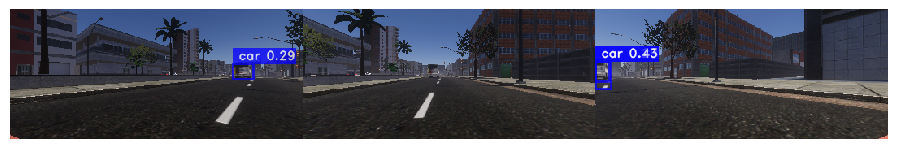

In [ ]:
import super_gradients

yolo_nas = super_gradients.training.models.get("yolo_nas_s", pretrained_weights="coco").cuda()
yolo_nas.predict("/content/Simulator/Dataset11/IMG/sub110/CapturedImage.png").show()

In [ ]:
from ultralytics import YOLO

# Load a model
model = YOLO("yolov8n.pt")  # load a pretrained model (recommended for training)

# Use the model
# model.train(data="coco128.yaml", epochs=3)  # train the model
# metrics = model.val()  # evaluate model performance on the validation set
results = model(torch.unsqueeze(dataset[0][0], 0))  # predict on an image
print(results)

100%|██████████| 6.23M/6.23M [00:00<00:00, 109MB/s]



ValueError: ignored